In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pygmt
import pyproj
from pyproj import Transformer
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates

# Extract the necessary columns (Lat, Lon, and Elev for plotting)
hypocenter_data = pd.read_excel("./input/2024_11.xlsx")
hypocenter_data['depth_km'] = hypocenter_data['Depth']/1000
hypocenter_data = hypocenter_data.rename(columns={
    "Lon": "longitude",
    "Lat": "latitude",
})

# hypocenter_data = pd.read_csv("D:/SERD/01_meq/reloc_wcctest.csv")
# hypocenter_data = hypocenter_data.rename(columns={
#     "lon": "longitude",
#     "lat": "latitude",
#     "depth": "depth_km",
#     "origin_time": "time"
# })



local_dem_file = 'D:/SERD/02_demnas/rantaudedap_dem.grd'


reloc_cat = pd.read_csv("./input/reloc.csv", parse_dates=["origin_time"])
reloc_cat = reloc_cat.rename(columns={
    "lon": "longitude",
    "lat": "latitude",
    #"depth": "depth_km",
    "origin_time": "time"
})

stations = pd.read_csv("./input/serd_stations.csv")
stations['depth_km'] = stations['elevation_m']/(-1000)
wellpad = pd.read_csv("./input/structures/wellpad.csv")

fault_gdf = gpd.read_file("./input/structures/Structures_2021.shp")

# Asumsikan CRS UTM pada fault_gdf (sesuai dengan UTM zona yang digunakan di dataset UTM)
utm_crs = fault_gdf.crs  # CRS asal (misalnya, EPSG:32747 untuk UTM zona 48)
wgs84_crs = "EPSG:4326"  # CRS untuk sistem geografis (longitude, latitude)

# Transformer untuk konversi dari UTM ke longitude, latitude
transformer = Transformer.from_crs(utm_crs, wgs84_crs, always_xy=True)

### WELL
shapefile_path = "./input/structures/Well_Trajectories_2018 Update.shp"
well_trajectories = gpd.read_file(shapefile_path)
well_trajectories = well_trajectories.to_crs("EPSG:4326")
well_traj = []
for _, row in well_trajectories.iterrows():
    x, y = row.geometry.xy
    well_traj.append({"lon": x, "lat": y})

In [2]:
hypocenter_data.head(3)

,ID,latitude,longitude,UTM_X,UTM_Y,Depth,Elev,Year,Month,Day,Hour,Minute,T0,RMS_error,N_Phases,GAP,PDF_errXX(m),PDF_errYY(m),PDF_errZZ(m),depth_km
0,1,-4.208389,103.373781,319503.024,9534650.202,-1.935,1.935,2024,11,1,14,56,39.857167,0.014263,8,285.255,380.400557,297.925716,204.050736,-0.001935
1,2,-4.210375,103.408644,323373.992,9534438.508,393.899,-393.899,2024,11,2,1,34,29.616276,0.040565,14,149.948,264.266559,453.634017,534.132734,0.393899
2,3,-4.241321,103.362952,318308.468,9531006.048,294.940,-294.940,2024,11,4,18,50,7.836062,0.026769,14,145.593,639.594489,603.864662,337.806529,0.294940


In [3]:
reloc_cat.head(3)

,id,time,longitude,latitude,utm_x,utm_y,depth_km,depth_m,elevation_m,elevation_km,magnitude,CID,RCC,RCT,remarks
0,1,2024-11-01 14:56:39.890,103.375106,-4.209617,319650.445198,9.534515e+06,-0.033,-33.0,33.0,0.033,0.0,1,0.000,0.029,WCC
1,4,2024-11-04 18:50:07.860,103.360270,-4.246070,318011.835502,9.530480e+06,-0.185,-185.0,185.0,0.185,0.0,1,0.010,0.029,WCC
2,6,2024-11-05 16:57:56.630,103.358398,-4.241896,317803.032938,9.530941e+06,-0.149,-149.0,149.0,0.149,0.0,1,0.014,0.024,WCC


In [4]:
stations.head(3)

,id,longitude,latitude,elevation_m,utmx,utmy,depth_km
0,RD01,103.408419,-4.192293,1504,323344.9658,9536437.964,-1.504
1,RD02,103.401842,-4.210773,1753,322618.9510,9534392.981,-1.753
2,RD03,103.390728,-4.205930,1899,321383.9716,9534925.980,-1.899


In [5]:
wellpad.head(3)

,id,name,remarks,longitude,latitude
0,1,B,Injection,103.40731,-4.21061
1,2,C,Production,103.37889,-4.22057
2,3,E,Injection,103.38168,-4.20694


# Fungsi

In [6]:
def process_and_get_elevation(hypocenter_data, reloc_cat, stations, local_dem_file, startx, endx, starty, endy, width=[-10, 10]):
    """
    Fungsi ini memproses data untuk penampang seismik dan menghitung hasil proyeksi serta profil elevasi.
    """
    # Proyeksi untuk data manual catalog
    penampang_init = pygmt.project(
        data=hypocenter_data[['longitude', 'latitude', 'depth_km']].values.tolist(),
        unit=True,
        center=[startx, starty],
        endpoint=[endx, endy],
        convention="pz",
        width=width,
    )
    
    # Proyeksi untuk data reloc HypoDD
    penampang_reloc = pygmt.project(
        data=reloc_cat[['longitude', 'latitude', 'depth_km']].values.tolist(),
        unit=True,
        center=[startx, starty],
        endpoint=[endx, endy],
        convention="pz",
        width=width,
    )
    
    # Proyeksi untuk data stations
    penampang_sta = pygmt.project(
        data=stations[['longitude', 'latitude', 'depth_km']].values.tolist(),
        unit=True,
        center=[startx, starty],
        endpoint=[endx, endy],
        convention="pz",
        width=width,
    )
    penampang_sta = penampang_sta.rename(columns={0: "p", 1: "z"})
    penampang_sta = penampang_sta.merge(
    stations[['id', 'depth_km']], 
    left_on='z',       
    right_on='depth_km',       
    how='left'          
    )

    # Mengambil profil elevasi
    penampang_elev = pygmt.project(
        center=f"{startx}/{starty}",
        endpoint=f"{endx}/{endy+0.01}",
        generate="0.0001",
    )
    
    penampang_elev = pygmt.grdtrack(
        grid=local_dem_file,
        points=penampang_elev,
        newcolname="elevation",
    )
    
    penampang_elev['elevation_km'] = penampang_elev['elevation'] / -1000
    penampang_elev['p_km'] = penampang_elev['p'] * 100
    
    return penampang_init, penampang_reloc, penampang_sta, penampang_elev

# Peta utama

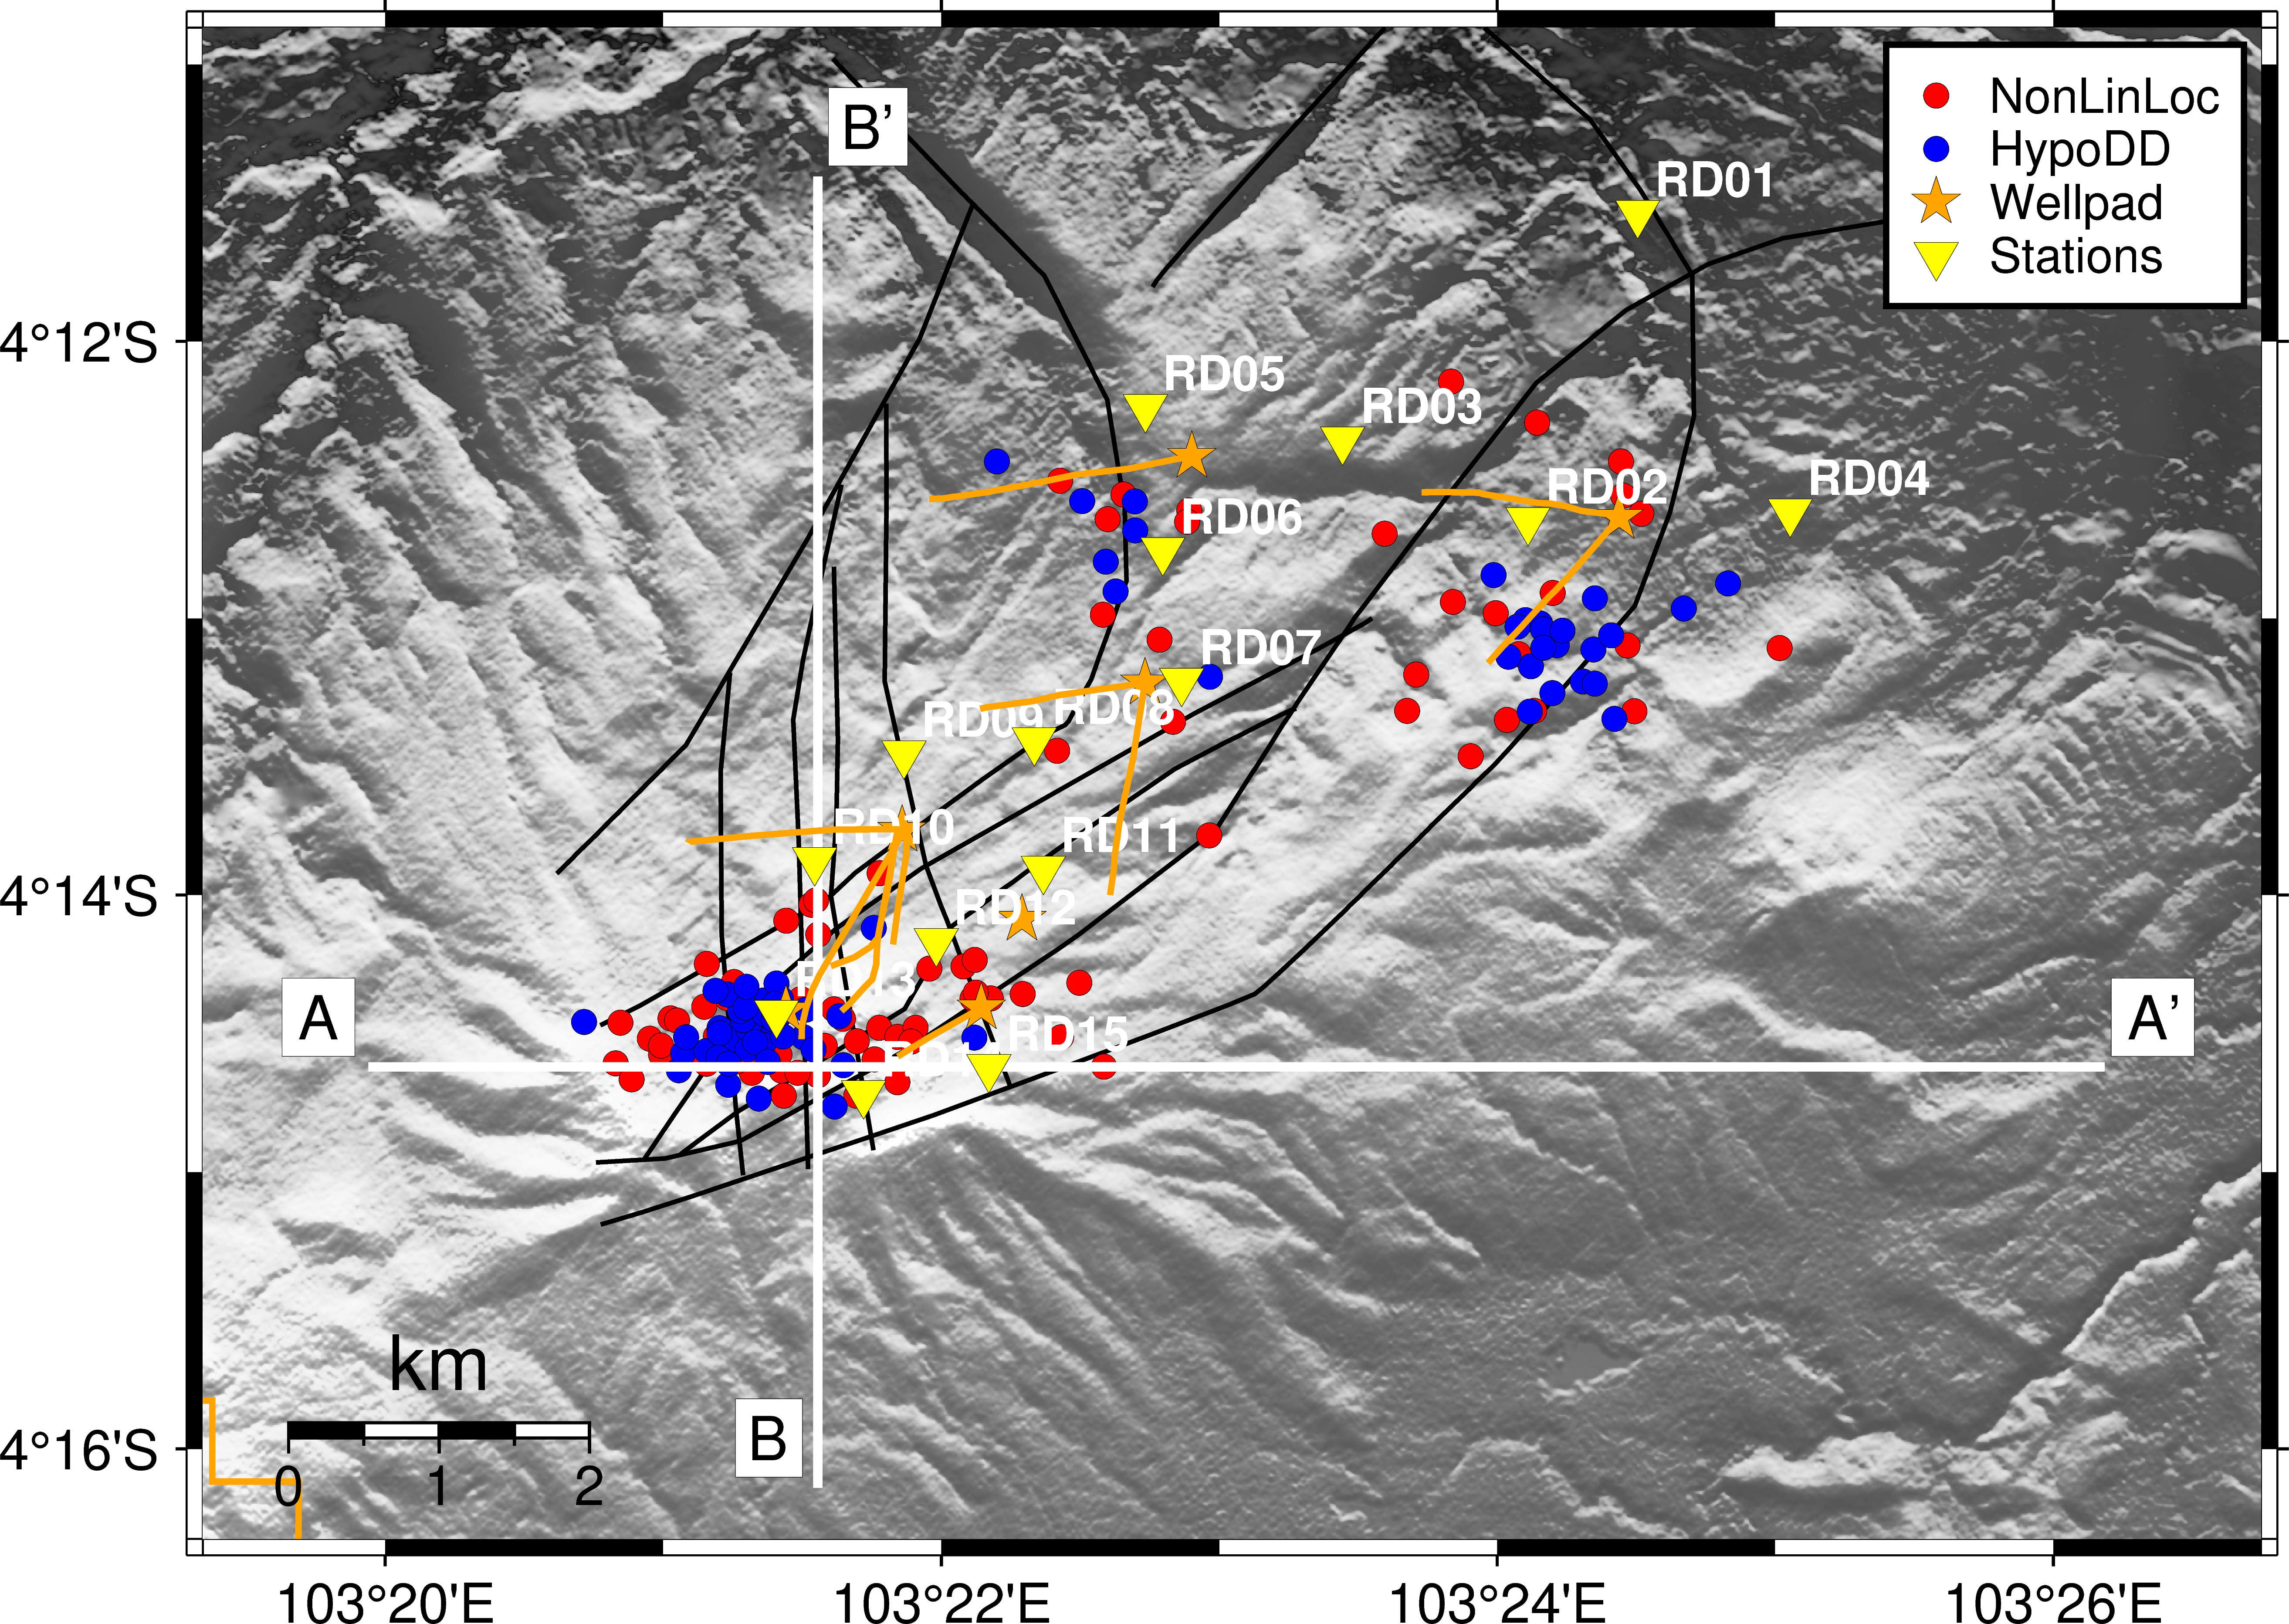

In [7]:
# Memproses penampang AA ######################################################################################################
axy_start = [103.33232430385, -4.2436879136414]
axy_end = [103.43640047377, -4.2436879136414]
penampang_a_init, penampang_a_reloc, penampang_a_sta, penampang_a_elev = process_and_get_elevation(
    hypocenter_data, reloc_cat, stations, local_dem_file, axy_start[0], axy_end[0], axy_start[1], axy_end[1], width=[-2, 2]
)

# Memproses penampang BB ######################################################################################################
bxy_start = [103.35925962278, -4.2690220081715]
bxy_end = [103.35925962278, -4.1900788791385]
penampang_b_init, penampang_b_reloc, penampang_b_sta, penampang_b_elev = process_and_get_elevation(
    hypocenter_data, reloc_cat, stations, local_dem_file, bxy_start[0], bxy_end[0], bxy_start[1], bxy_end[1], width=[-2, 2]
)

# Define map region based on the range of the hypocenter data
region = [103.32239833986, 103.44579616099, -4.2720923331116, -4.1811164061925]

# Create a PyGMT figure for map view (longitude vs latitude) without DEM
fig = pygmt.Figure()

# Create a base map without DEM (just a simple map)
fig.basemap(region=region, projection="M12c", frame=True)

# Plot hillshade grid as background
fig.grdimage(grid=local_dem_file, projection="M12c", cmap="gray", shading='+a5+m0', transparency=40)


# Plot fault lines after transforming UTM to longitude, latitude
for _, fault in fault_gdf.iterrows():
    # Extract the geometry of the fault line (in UTM)
    x_fault, y_fault = fault.geometry.xy
    
    # Transform UTM to longitude, latitude
    lon_fault, lat_fault = transformer.transform(x_fault, y_fault)
    
    # Plot the transformed fault lines
    fig.plot(x=lon_fault, y=lat_fault, pen="0.75p,black")
    

## Plot hypocenters as red circles (manual catalog)
fig.plot(
    x=hypocenter_data['longitude'],
    y=hypocenter_data['latitude'],
    style="c0.15c",
    fill="red",  # Red color for the hypocenters
    pen="faint",
    label="NonLinLoc"
)

## Plot relocated hypocenters as blue circles (HypoDD)
fig.plot(
    x=reloc_cat['longitude'],
    y=reloc_cat['latitude'],
    style="c0.15c",
    fill="blue",  # Blue color for the reloc hypocenters
    pen="faint",
    label="HypoDD"
)


fig.plot(
    x=wellpad['longitude'], y=wellpad['latitude'],
    style="a0.3c", pen='faint', fill="orange", label="Wellpad"
)

# Plot cross-section line AA
fig.plot(x=[axy_start[0], axy_end[0]], y=[axy_start[1], axy_end[1]], projection="M", pen="1.5p,white")
fig.text(x=axy_start[0]-0.003, y=axy_start[1]+0.003, text="A", font="10,Helvetica", fill="white", clearance="0.1c", pen=0)
fig.text(x=axy_end[0]+0.003, y=axy_end[1]+0.003, text="A'", font="10,Helvetica", fill="white", clearance="0.1c", pen=0)

# Plot cross-section line BB
fig.plot(x=[bxy_start[0], bxy_end[0]], y=[bxy_start[1], bxy_end[1]], projection="M", pen="1.5p,white")
fig.text(x=bxy_start[0]-0.003, y=bxy_start[1]+0.003, text="B", font="10,Helvetica", fill="white", clearance="0.1c", pen=0)
fig.text(x=bxy_end[0]+0.003, y=bxy_end[1]+0.003, text="B'", font="10,Helvetica", fill="white", clearance="0.1c", pen=0)


# Add labels (e.g., "id") to each station
for _, station in stations.iterrows():
    fig.text(
        x=station['longitude'], y=station['latitude'],
        text=str(station['id']),  # Replace 'id' with the actual column name containing the station IDs
        font="8p,Helvetica-Bold,white",
        offset="0.1c/0.2c",  # Adjust label positioning relative to the station marker
        justify="ML",  # Left alignment
    )


## Plot garis lintasan sumur
for line in well_traj:
    fig.plot(x=line["lon"], y=line["lat"], pen="1p,orange")

# Plot station locations as yellow triangles
fig.plot(
    x=stations['longitude'], y=stations['latitude'],
    style="i0.3c", pen='faint', fill="yellow", label="Stations"
)

# Add a legend
with pygmt.config(FONT_ANNOT_PRIMARY="8p"):
    fig.legend(position="JTR+jTR+o0.1c", box="+gwhite+p1p")
    
fig.basemap(
    map_scale="jBL+o0.5c/0.5c+w2k+f+lkm",  # Adjust the location and appearance of the scale bar
    transparency=0,
    #box="+gwhite@30+p0.25p,gray30,solid+r3p",  # Add a box with rounded edges around the scale bar
)

# Show the figure
fig.show(dpi=1000, width=750)

### Penampang AA'

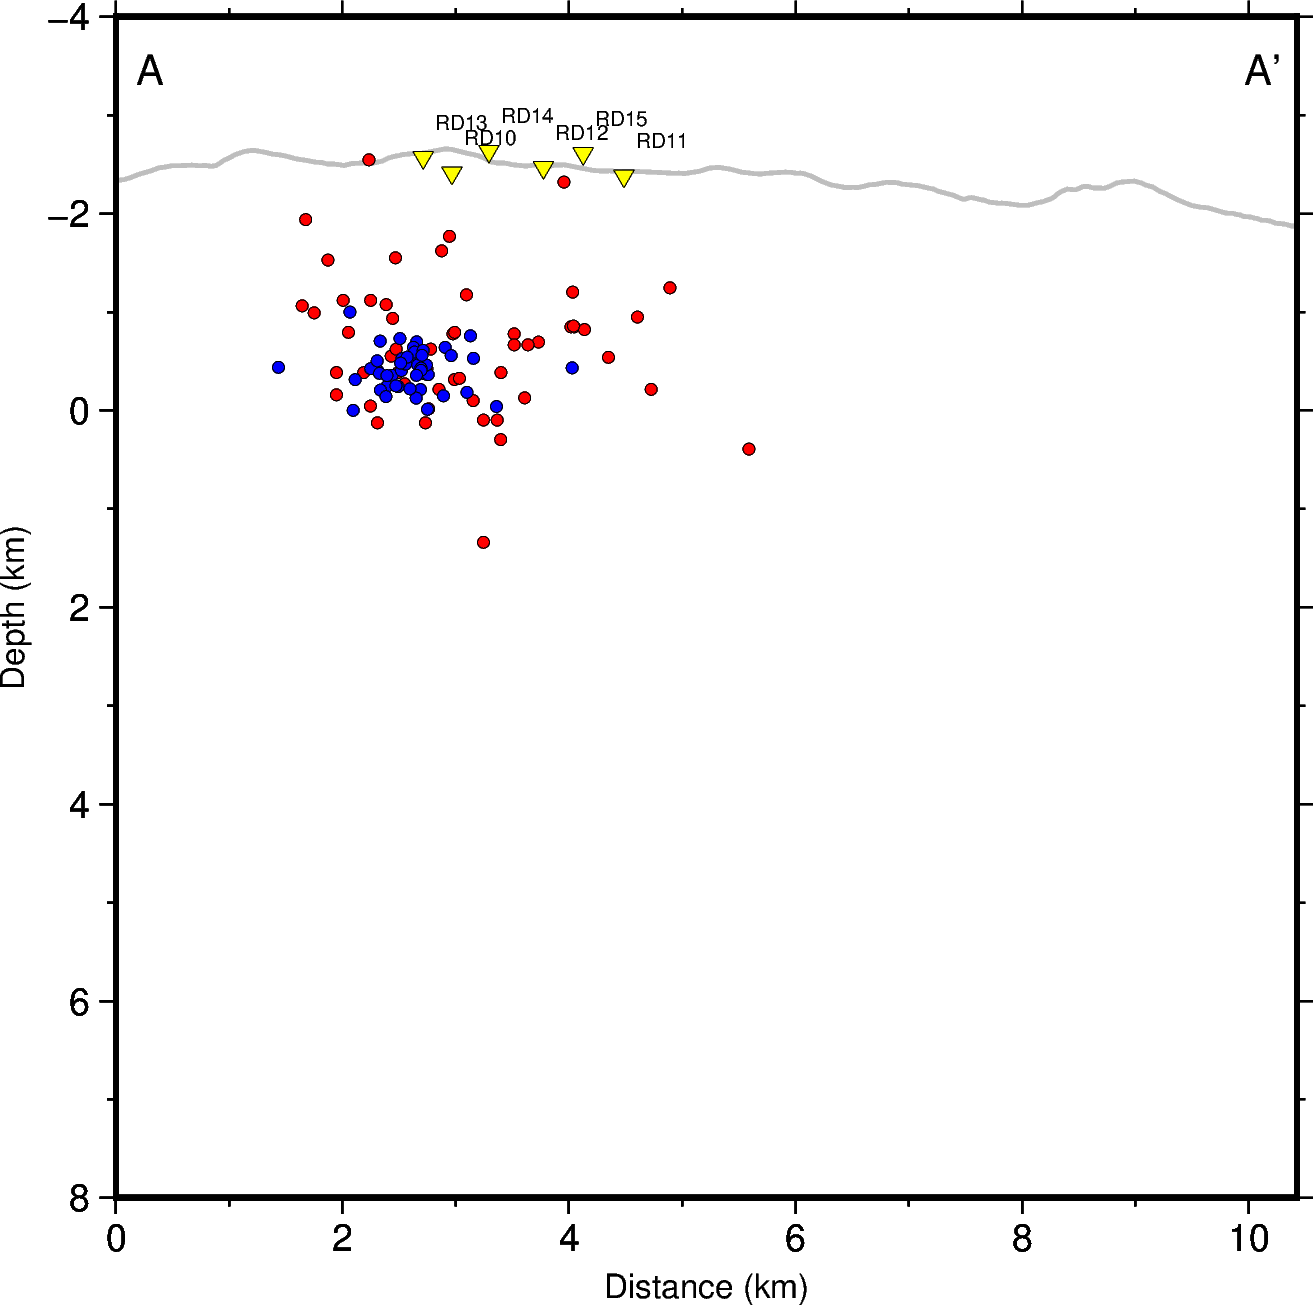

In [8]:
# Create a PyGMT figure for map view (longitude vs latitude) without DEM
fig = pygmt.Figure()

# Set font size for labels and annotations (tick marks)
pygmt.config(FONT_LABEL="8p")  # Adjust font sizes

# Set up the basemap with y-ticks every 2 km and smaller font size for labels
fig.basemap(
    projection="X10c/-10c",
    region=[0, penampang_a_elev['p_km'].max(), -4, 8],
    frame=['xaf+lDistance (km)', 'ya2f+lDepth (km)', "WSen"],  # ya2 sets y-ticks every 2 km
)


fig.plot(
    x=penampang_a_elev.p_km,
    y=penampang_a_elev['elevation_km'],
    pen="1p,grey",
    frame=True,  
)

fig.plot(data=penampang_a_init, style="c0.1c", pen='faint', fill="red")
fig.plot(data=penampang_a_reloc, style="c0.1c", pen='faint', fill="blue")
fig.plot(x=penampang_a_sta.p, y=penampang_a_sta.z, style="i0.2c", pen='faint', fill="yellow")

for _, station in penampang_a_sta.iterrows():
    fig.text(
        x=station['p'], y=station['z'],
        text=str(station['id']),  # Replace 'id' with the actual column name containing the station IDs
        font="5p,Helvetica,black",
        offset="0.1c/0.3c",  # Adjust label positioning relative to the station marker
        justify="ML",  # Left alignment
    )
    
fig.text(text="A", x=0.3, y=penampang_a_elev['elevation_km'].min()-0.8, font="10,Helvetica", fill="white")
fig.text(text="A'", x=penampang_a_elev['p_km'].max()-0.3, y=penampang_a_elev['elevation_km'].min()-0.8, font="10,Helvetica", fill="white")
fig.show()

### Penampang BB'

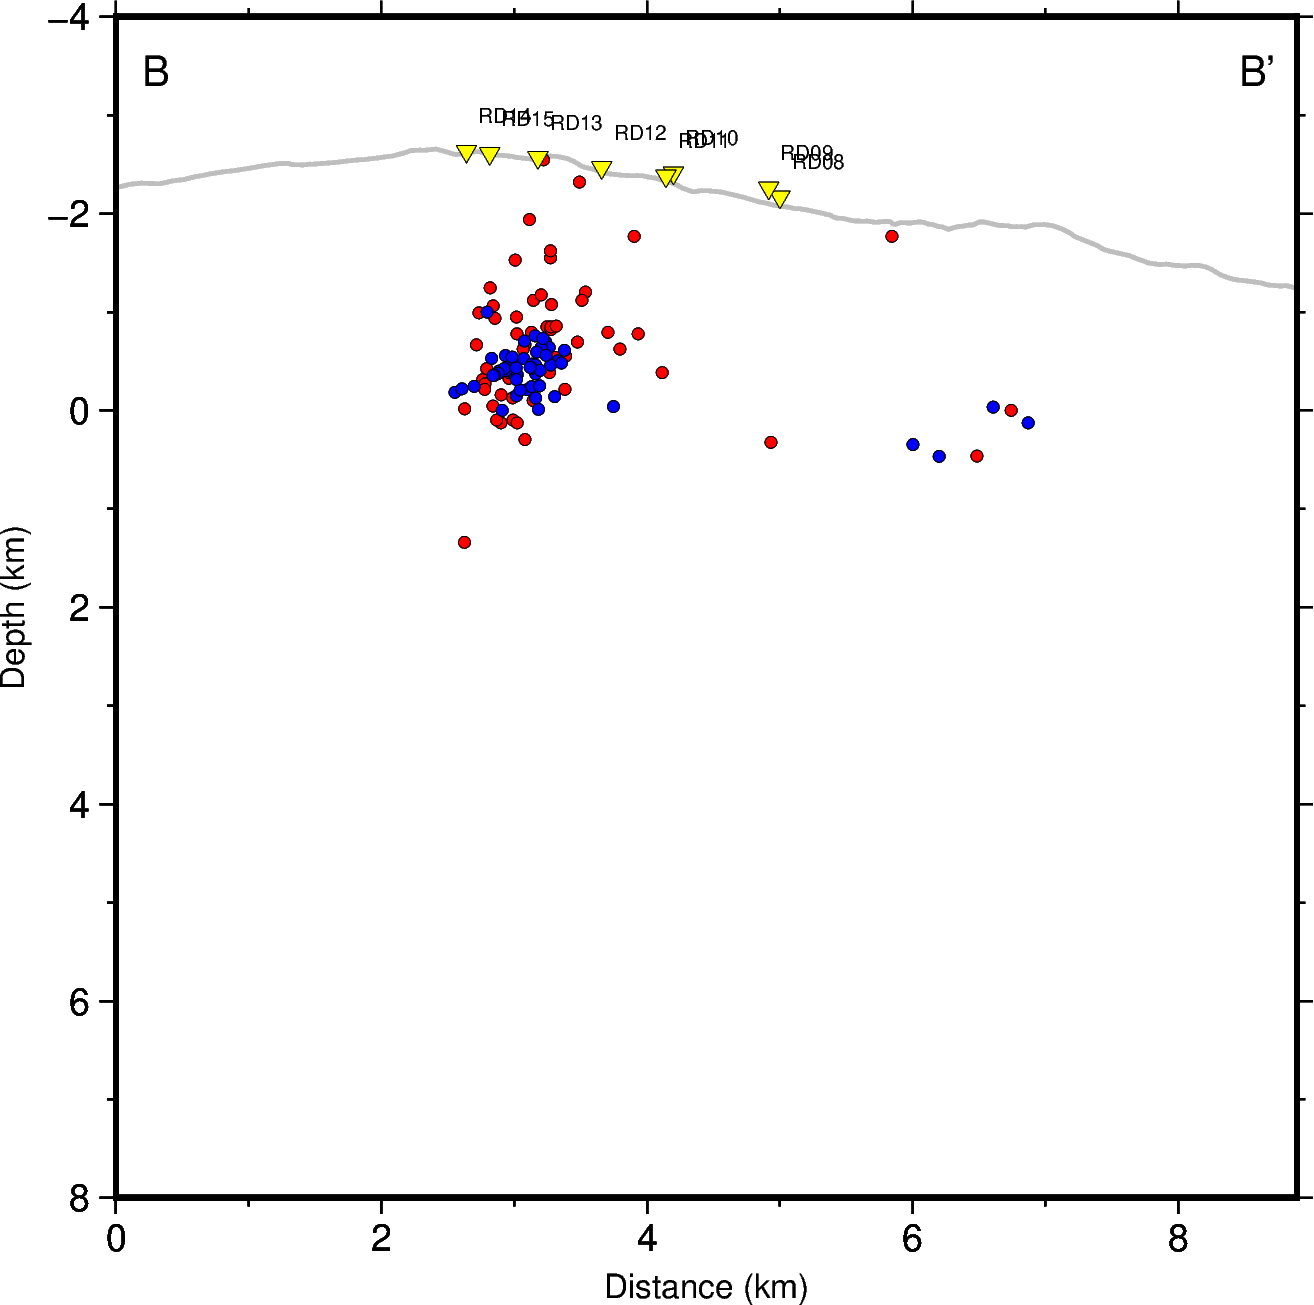

In [9]:
# Create a PyGMT figure for map view (longitude vs latitude) without DEM
fig = pygmt.Figure()

# Set font size for labels and annotations (tick marks)
pygmt.config(FONT_LABEL="8p")  # Adjust font sizes

# Set up the basemap with y-ticks every 2 km and smaller font size for labels
fig.basemap(
    projection="X10c/-10c",
    region=[0, penampang_b_elev['p_km'].max(), -4, 8],
    frame=['xaf+lDistance (km)', 'ya2f+lDepth (km)', "WSen"],  # ya2 sets y-ticks every 2 km
)


fig.plot(
    x=penampang_b_elev.p_km,
    y=penampang_b_elev['elevation_km'],
    pen="1p,grey",
    frame=True,  
)

fig.plot(data=penampang_b_init, style="c0.1c", pen='faint', fill="red")
fig.plot(data=penampang_b_reloc, style="c0.1c", pen='faint', fill="blue")
fig.plot(x=penampang_b_sta.p, y=penampang_b_sta.z, style="i0.2c", pen='faint', fill="yellow")

for _, station in penampang_b_sta.iterrows():
    fig.text(
        x=station['p'], y=station['z'],
        text=str(station['id']),  # Replace 'id' with the actual column name containing the station IDs
        font="5p,Helvetica,black",
        offset="0.1c/0.3c",  # Adjust label positioning relative to the station marker
        justify="ML",  # Left alignment
    )


fig.text(text="B", x=0.3, y=penampang_b_elev['elevation_km'].min()-0.8, font="10,Helvetica", fill="white")
fig.text(text="B'", x=penampang_b_elev['p_km'].max()-0.3, y=penampang_b_elev['elevation_km'].min()-0.8, font="10,Helvetica", fill="white")
fig.show()

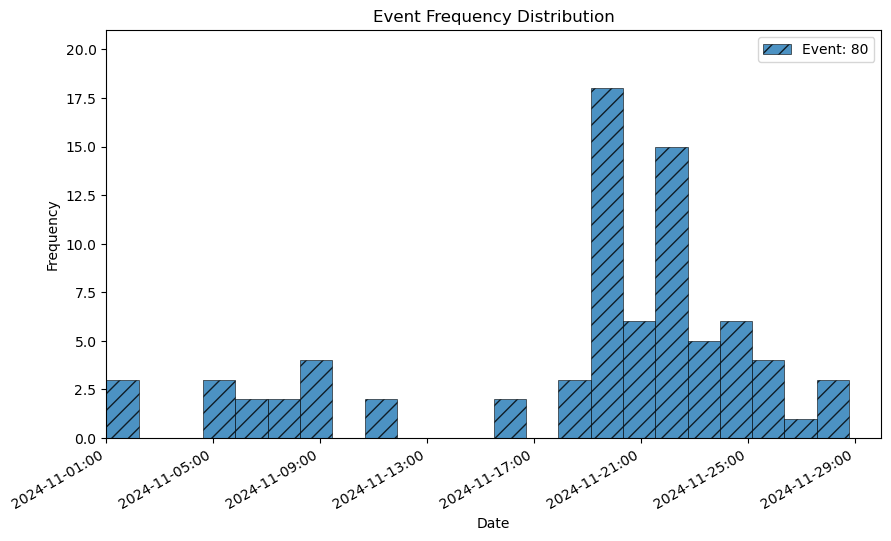

In [10]:
starttime = '2024-11-01 00:00:00' #reloc_cat["time"].min()
endtime = '2024-11-30 00:00:00' #reloc_cat["time"].max()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(
    reloc_cat["time"],
    range=(starttime, endtime),
    bins=24,
    edgecolor="k",
    alpha=0.8,
    linewidth=0.5,
    label=f"Event: {len(reloc_cat['time'])}",
    #color='red',
    hatch='//'  # Add hatch pattern for the bars
)
plt.ylabel("Frequency")
plt.ylim(0,21)
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.title("Event Frequency Distribution")
plt.show()